In [45]:
import pickle
from typing import List, Any, Dict, Tuple, Set, Iterable, Sequence
from operator import itemgetter
from itertools import combinations, starmap, groupby, product, chain, islice

import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from conversant.conversation import Conversation
from conversant.conversation.parse import DataFrameConversationReader
from conversant.interactions import InteractionsGraph
from conversant.interactions.interactions_graph import PairInteractionsData
from conversant.interactions.reply_interactions_parser import get_reply_interactions_parser
from stance_classification.classifiers.base_stance_classifier import BaseStanceClassifier
from stance_classification.classifiers.greedy_stance_classifier import MSTStanceClassifier
from stance_classification.data.iac import FourForumInteractionsBuilder
from stance_classification.data.iac.fourforum_data import load_post_records, build_conversations
from stance_classification.data.iac.fourforum_labels import load_author_labels, AuthorLabel
from stance_classification.draw_utils import new_figure
%matplotlib inline

from stance_classification.classifiers.maxcut_stance_classifier import MaxcutStanceClassifier

In [46]:
base_dir = "/Users/ronpick/studies/stance/alternative/createdebate_released"
data_path = f"{base_dir}/post.txt"
header = ["discussion_id", "post_id", "author_id", "creation_date", "parent_post_id",
          "parent_missing", "text_id", "points", "discussion_stance_id", "is_rebuttal"]

df = pd.read_csv(data_path, sep='\t', names=header, na_values="\\N")
df

,discussion_id,post_id,author_id,creation_date,parent_post_id,parent_missing,text_id,points,discussion_stance_id,is_rebuttal
0,878,3557,27083,2008-05-07 23:06:11,NaN,0,513135,-3,0.0,NaN
1,878,3563,5901,2008-05-08 01:25:25,NaN,0,513160,-8,0.0,NaN
2,878,3623,11010,2008-05-08 15:03:14,NaN,0,513211,11,1.0,NaN
3,878,3627,27083,2008-05-08 15:21:42,3623.0,0,513212,8,0.0,disputed
4,878,3632,8705,2008-05-08 15:35:54,NaN,0,513276,4,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...
3046,56718,558884,1488,2014-05-09 05:30:18,NaN,0,771300,1,0.0,NaN
3047,56718,558914,2827,2014-05-09 13:40:52,558884.0,0,771301,1,1.0,disputed
3048,56718,558915,2827,2014-05-09 13:41:09,NaN,0,771304,1,1.0,NaN
3049,56718,558927,2496,2014-05-09 16:26:02,558914.0,0,771302,1,1.0,supported


In [47]:
discussions_info_path = f"{base_dir}/discussion.txt"
discussions_header = ["discussion_id", "link", "title", "op", "description_id"]

op_df = pd.read_csv(discussions_info_path, sep='\t', names=discussions_header, na_values="\\N")
discussion_op_map = list(zip(op_df["discussion_id"], op_df["op"]))
discussion_title_map = dict(zip(op_df["discussion_id"], op_df["title"]))
discussion_inittext_map = dict(zip(op_df["discussion_id"], op_df["description_id"]))
len(discussion_op_map)

63

In [48]:
discussions_topic_path = f"{base_dir}/discussion_topic.txt"
discussions_topic_header = ["discussion_id", "topic_id"]

topic_df = pd.read_csv(discussions_topic_path, sep='\t', names=discussions_topic_header)
discussion_topic_map = dict(zip(topic_df["discussion_id"], topic_df["topic_id"]))
len(discussion_topic_map)


63

In [49]:
df["root_discussion_id"] = df["discussion_id"]

#### fill all missing parents as direct replies to the discussion title (with post id as the discussion's

In [50]:
df["parent_post_id"] = df.apply(
    lambda row: row["discussion_id"] if pd.isna(row["parent_post_id"]) else row["parent_post_id"],
    axis=1
)
df["parent_post_id"]

0          878.0
1          878.0
2          878.0
3         3623.0
4          878.0
          ...   
3046     56718.0
3047    558884.0
3048     56718.0
3049    558914.0
3050    558884.0
Name: parent_post_id, Length: 3051, dtype: float64

#### add the first post to the dataframe
add the title of the discussion as posts in the discussion, so the conversation parser would add them as records.


In [51]:
new_records = []
for discussion_id, op in discussion_op_map:
    init_text_id = discussion_inittext_map[discussion_id]
    init_text_id = int(init_text_id) if not pd.isna(init_text_id) else None

    title = discussion_title_map[discussion_id]
    title = int(title) if not pd.isna(title) else None
    record = {
        "discussion_id": discussion_id,
        "post_id": discussion_id,
        "author_id": op,
        "creation_date": "00:00",
        "parent_post_id": None,
        "parent_missing": 0,
        "text_id": init_text_id,
        "points": -1,
        "discussion_stance_id": 0.5,
        "is_rebuttal": None,
        "title": title
    }
    new_records.append(record)

df = df.append(new_records, ignore_index=True)

ValueError: invalid literal for int() with base 10: 'Should guns be banned in America?'

In [52]:
# add topic to the df
df["topic"] = df.apply(lambda row: discussion_topic_map[row["discussion_id"]], axis=1)
df["title"] = df.apply(lambda row: discussion_title_map[row["discussion_id"]], axis=1)
df

,discussion_id,post_id,author_id,creation_date,parent_post_id,parent_missing,text_id,points,discussion_stance_id,is_rebuttal,root_discussion_id,topic,title
0,878,3557,27083,2008-05-07 23:06:11,878.0,0,513135,-3,0.0,NaN,878,9,Should guns be banned in America?
1,878,3563,5901,2008-05-08 01:25:25,878.0,0,513160,-8,0.0,NaN,878,9,Should guns be banned in America?
2,878,3623,11010,2008-05-08 15:03:14,878.0,0,513211,11,1.0,NaN,878,9,Should guns be banned in America?
3,878,3627,27083,2008-05-08 15:21:42,3623.0,0,513212,8,0.0,disputed,878,9,Should guns be banned in America?
4,878,3632,8705,2008-05-08 15:35:54,878.0,0,513276,4,1.0,NaN,878,9,Should guns be banned in America?
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,56718,558884,1488,2014-05-09 05:30:18,56718.0,0,771300,1,0.0,NaN,56718,9,gun control
3047,56718,558914,2827,2014-05-09 13:40:52,558884.0,0,771301,1,1.0,disputed,56718,9,gun control
3048,56718,558915,2827,2014-05-09 13:41:09,56718.0,0,771304,1,1.0,NaN,56718,9,gun control
3049,56718,558927,2496,2014-05-09 16:26:02,558914.0,0,771302,1,1.0,supported,56718,9,gun control


In [58]:
df.to_csv("/Users/ronpick/workspace/zero-shot-stance/data/createdebate/iac-createdebate-subconvs.csv", index=False)

In [54]:
pasre_strategy = {
    "node_id": "post_id",
    "author": "author_id",
    "timestamp": "creation_date",
    "parent_id": "parent_post_id"
    }
parser = DataFrameConversationReader(pasre_strategy)
gb = df.groupby("discussion_id")
convs: List[Conversation] = list(tqdm(map(parser.parse, map(itemgetter(1), gb))))
len(convs)

63

In [55]:
sub_convs = [Conversation(child) for conv in convs for child in conv.root.children]
len(sub_convs)

74

# conversation stats

In [56]:
sizes = [c.size for c in sub_convs]
print(len(sizes))
print(np.mean(sizes))
print(np.median(sizes))
pd.Series(sizes).describe()

74
5.4324324324324325
2.0


count    74.000000
mean      5.432432
std       8.810145
min       1.000000
25%       1.000000
50%       2.000000
75%       5.750000
max      54.000000
dtype: float64

<AxesSubplot:ylabel='Frequency'>

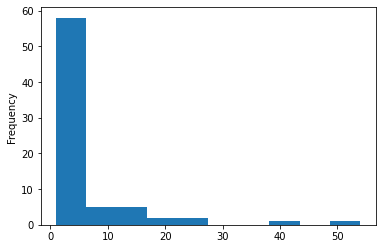

In [57]:
pd.Series(sizes).plot.hist()

In [ ]:
filtered_sizes = [s for s in sizes if s >= 10]
print(len(filtered_sizes))
print(np.mean(filtered_sizes))
print(np.median(filtered_sizes))


In [ ]:
def decide_stance(self, graph: nx.Graph, cut_nodes: Set[Any], labeled_nodes: Dict[Any, int]) -> int:
    """
    :param labeled_nodes:
    :param graph:
    :param cut_nodes:
    :param weight_field:
    :return: return the inferred stance label of the cut nodes.
    """
    if self.op in self.graph.nodes:
        pivot_node = self.op
    else:
        pivot_node = self.__get_ordered_candidates_for_pivot(graph)

    cut_nodes_support = pivot_node in cut_nodes
    return int(cut_nodes_support)

def get_ordered_candidates_for_pivot(graph: nx.Graph, weight_field: str = "weight") -> Sequence[Any]:
    inv_weight_field = "inv_weight"
    for _, _, pair_data in graph.edges(data=True):
        weight = pair_data.data[weight_field]
        pair_data.data[inv_weight_field] = 1 / weight

    node_centralities = nx.closeness_centrality(graph, distance=inv_weight_field)
    return list(map(itemgetter(0), sorted(node_centralities.items(), key=itemgetter(1), reverse=True)))

def get_pivot_node(graph: nx.Graph, labeled_authors: Set[Any], weight_field: str = "weight") -> Any:
    candidates = get_ordered_candidates_for_pivot(graph, weight_field=weight_field)
    return next(iter(filter(labeled_authors.__contains__, candidates)), None)

## Load Author labels

In [ ]:
def get_majority_vote(labels: List[int]) -> int:
    return int(np.mean(labels) >= 0.5)

def get_author_labels(c: Conversation) -> Dict[Any, int]:
    authors_post_labels = {}
    for depth, node in c.iter_conversation():
        data = node.data
        author = node.author
        current_author_labels = authors_post_labels.setdefault(author, [])
        current_author_labels.append(data["discussion_stance_id"])

    result_labels = {a: get_majority_vote(labels) for a, labels in authors_post_labels.items()}
    return result_labels

author_labels_per_conversation = {c.id: get_author_labels(c) for c in sub_convs}
author_labels_per_conversation = {k: v for k, v in author_labels_per_conversation.items() if len(v) > 0}
print(len(author_labels_per_conversation))
print(sum(len(v) for v in author_labels_per_conversation.values()))

## Load posts labels (Chang Li)

In [ ]:
def load_post_label_mapping(path: str) -> Dict[str, int]:
    with open(path, 'rb') as f:
        return pickle.load(f)

def decode_original_post_identification(post_id: str) -> Tuple[str, int, int]:
    topic, numeric_id = post_id.split('.')
    original_discussion_index = int(numeric_id[:-5])
    original_post_index = int(numeric_id[-3:])
    return topic, original_discussion_index, original_post_index


labels_path = "/home/dev/data/stance/chang-li/data/compressed-4forum/allPostLabelMap.pickle"
raw_post_labels = load_post_label_mapping(labels_path)
post_labels = {itemgetter(1,2)(decode_original_post_identification(raw_post_id)): (stance % 2) for (raw_post_id, stance) in raw_post_labels.items()}
len(post_labels)

In [ ]:
def get_author_labels(conv: Conversation) -> Dict[Any, int]:
    if conv.id not in author_labels_per_conversation:
        return None

    return author_labels_per_conversation[conv.id]

def get_maxcut_results(graph: InteractionsGraph, op: Any) -> MaxcutStanceClassifier:
    maxcut = MaxcutStanceClassifier(weight_field=graph.WEIGHT_FIELD)
    maxcut.set_input(graph.graph, op)
    maxcut.classify_stance()
    return maxcut

def get_greedy_results(graph: InteractionsGraph, op: Any) -> BaseStanceClassifier:
    clf = MSTStanceClassifier()#weight_field=graph.WEIGHT_FIELD)
    clf.set_input(graph.graph)
    clf.classify_stance(op)
    return clf

def get_author_preds(clf: BaseStanceClassifier, pivot: Any) -> Dict[Any, int]:
    support_label = authors_labels[pivot]
    opposer_label = 1 - support_label
    supporters = clf.get_supporters()
    opposers = clf.get_complement()
    preds = {}
    for supporter in supporters:
        preds[supporter] = support_label
    for opposer in opposers:
        preds[opposer] = opposer_label

    return preds

def align_gs_with_predictions(authors_labels: Dict[Any, int], author_preds: Dict[Any, int]) -> Tuple[List[int], List[int]]:
    y_true, y_pred = [], []
    for author, true_label in authors_labels.items():
        pred = author_preds.get(author, None)
        if pred is None: continue

        y_true.append(true_label)
        y_pred.append(pred)

    return y_true, y_pred

def align_posts_gs_with_predictions(conv: Conversation, author_preds: Dict[Any, int]) -> Tuple[List[int], List[int]]:
    y_true, y_pred = [], []
    for (_, node) in conv.iter_conversation():
        label = node.data["discussion_stance_id"]
        if label == 0.5: continue
        if pd.isna(label): continue
        pred = author_preds.get(node.author, None)
        if pred is None: continue

        y_true.append(label)
        y_pred.append(pred)

    return y_true, y_pred


def predict_for_partition(true: List[int], preds: List[int]) -> Tuple[List[int], List[int]]:
    acc = accuracy_score(true, preds)
    if acc < 0.5:
        preds = [1-l for l in preds]

    return true, preds


In [ ]:
interactions_parser = get_reply_interactions_parser()
author_true, author_pred = [], []
author_true_best, author_pred_best = [], []
posts_true, posts_pred = [], []
post_true_best, post_pred_best = [], []
filtered_convs = []
pivot_nodes = []
full_graphs = []
core_graphs = []
maxcut_results: Dict[Any, MaxcutStanceClassifier] = {}
classification_results: List[Tuple[List[int], List[int]]] = []
empty_core = []
unlabeled_conversations = []
unlabeled_op = []
insufficient_author_labels = []
too_small_cut_value = []
op_not_in_core = []
large_graphs = []

def calc_weight(interactions: PairInteractionsData) -> float:
    n_replies = interactions["replies"]
    # n_quotes = interactions["quotes"]
    return n_replies
    # return n_quotes

"""abortion = 3
   gay marriage = 8
   marijuana = 10
   obamacare = 15
   """
# convs[0].root.data["topic"]
# conv: Conversation
relevant_topics = {3,8,10,15}
count_conv = 0
for i, conv in tqdm(enumerate(sub_convs)):
    # topic = conv.root.data["topic"]
    # print(topic)
    # if topic not in relevant_topics: continue
    count_conv += 1
    authors_labels = get_author_labels(conv)
    if authors_labels is None:
        unlabeled_conversations.append(i)
        continue

    op = conv.root.author
    if op not in authors_labels:
        unlabeled_op.append(i)
        continue

    if len(authors_labels) < 3:
        insufficient_author_labels.append(i)
        continue

    interaction_graph = interactions_parser.parse(conv)

    interaction_graph.set_interaction_weights(calc_weight)
    zero_edges = [(v, u) for v, u, d in interaction_graph.graph.edges(data=True) if d["weight"] == 0]
    interaction_graph.graph.remove_edges_from(zero_edges)

    pivot_node = get_pivot_node(interaction_graph.graph, authors_labels, weight_field="weight")
    clf = get_greedy_results(interaction_graph, pivot_node)

    core_interactions = interaction_graph.get_core_interactions()
    if core_interactions.graph.size() == 0:
        empty_core.append(i)

    if core_interactions.graph.size() > 0:
        components = list(nx.connected_components(core_interactions.graph))
        core_interactions = core_interactions.get_subgraph(components[0])
        pivot_node = get_pivot_node(core_interactions.graph, authors_labels, weight_field="weight")
        pivot_nodes.append(pivot_node)
        maxcut = get_maxcut_results(core_interactions, pivot_node)
        if maxcut.cut_value < 3:
            too_small_cut_value.append(i)
        else:
            maxcut_results[conv.id] = maxcut
            clf = maxcut

    if core_interactions.graph.order() > 120:
        large_graphs.append(conv)
        continue

    authors_preds = get_author_preds(clf, pivot_node)

    true, preds = align_gs_with_predictions(authors_labels, authors_preds)
    author_true.append(true)
    author_pred.append(preds)

    true_best, preds_best = predict_for_partition(true, preds)
    author_true_best.append(true_best)
    author_pred_best.append(preds_best)

    true, preds = align_posts_gs_with_predictions(conv, authors_preds)
    posts_true.append(true)
    posts_pred.append(preds)

    true, preds = predict_for_partition(true, preds)
    post_true_best.append(true)
    post_pred_best.append(preds)

    filtered_convs.append(conv)
    full_graphs.append(interaction_graph)
    core_graphs.append(core_interactions)
    classification_results.append((true, preds))

In [ ]:
print(f"total number of conversations (in all topics): {len(sub_convs)}")
print(f"total number of conversations (in the relevant topics): {count_conv}")
print(f"total number of conversations with labeled authors (in all topics): {len(author_labels_per_conversation)}")
print(f"total number of conversations with labeled authors (in the relevant topics): {count_conv - len(unlabeled_conversations)}")

print(f"number of conversations in eval: {len(filtered_convs)}")
labeled_authors = sum(len(v) for v in author_labels_per_conversation.values())
print(f"total number of labeled authors: {labeled_authors}")
print(f"number of authors in eval: {sum(map(len, author_true))}")
print(f"number of posts in eval: {sum(map(len, posts_true))}")
print("=========")
print(f"number of conversations with empty core: {len(empty_core)}")
print(f"number of conversations with op not in core: {len(op_not_in_core)}")
print(f"number of conversations with too large core: {len(large_graphs)}")
print(f"number of conversations with too small cut value: {len(too_small_cut_value)}")
print(f"number of unlabeled conversations: {len(unlabeled_conversations)}")
print(f"number of conversations with unlabeled op: {len(unlabeled_op)}")
print(f"number of conversations with insufficient labeled authors: {len(insufficient_author_labels)}")


In [ ]:
# i, size = not_in_core_sorted[20]
# print("index", i)
# "size", size

In [ ]:
# c = sub_convs[i]
# print(c.op)
# ig = interactions_parser.parse(c)
# ig.set_interaction_weights(calc_weight)
# pos = nx.spring_layout(ig.graph, seed=19191)
# nx.draw_networkx(ig.graph, pos)

In [ ]:
# sorted(nx.closeness_centrality(ig.graph, distance="replies").items(), key=itemgetter(1), reverse=True)

In [ ]:
# core = ig.get_core_interactions()
# pos = nx.spring_layout(core.graph, seed=19191)
# nx.draw_networkx(core.graph, pos)

In [ ]:
# nx.closeness_centrality(core.graph, distance="weight")

In [ ]:
# labeled_authors = author_labels_per_conversation[c.id].keys()
# get_pivot_node(core.graph, labeled_authors, weight_field="weight")

In [ ]:
# list(core.graph.edges(data=True))

In [ ]:
y_true = list(chain(*author_true))
y_pred = list(chain(*author_pred))
print(classification_report(y_true, y_pred))

In [ ]:
y_true = list(chain(*author_true_best))
y_pred = list(chain(*author_pred_best))
print(classification_report(y_true, y_pred))

In [ ]:
y_pred = [l%2 for l in list(chain(*posts_true))]
y_true = list(chain(*posts_pred))
print(classification_report(y_true, y_pred))

In [ ]:
y_pred = [l%2 for l in list(chain(*post_true_best))]
y_true = list(chain(*post_pred_best))
print(classification_report(y_true, y_pred))

In [ ]:
def compute_pairs_average_distance(
        pairs: Iterable[Tuple[int, int]],
        embeddings: Sequence[np.ndarray]
) -> float:
    distances = list(starmap(lambda i, j: cosine(embeddings[i], embeddings[j]), pairs))
    return float(np.mean(distances))


def compute_average_angle_from_node(
        node_index: int,
        group_indices: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = ((node_index, i) for i in group_indices)
    return compute_pairs_average_distance(pairs, embeddings)


def compute_group_average_angle(
        group_indices: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = combinations(group_indices, 2)
    return compute_pairs_average_distance(pairs, embeddings)


def compute_cross_groups_average_angle(
        group1: Sequence[int],
        group2: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = product(group1, group2)
    return compute_pairs_average_distance(pairs, embeddings)

In [ ]:

supporters_avg_angles = []
opposers_avg_angles = []
mean_cross_angle = []
op2supporters = []
op2opposers = []
for i in range(len(maxcut_results)):
    maxcut = maxcut_results[i]
    op, all_embeddings, supporters, opposers =\
        maxcut.op, maxcut.embeddings, maxcut.get_supporters(), maxcut.get_complement()

    op2supporters.append(compute_average_angle_from_node(op, supporters, all_embeddings))
    op2opposers.append(compute_average_angle_from_node(op, opposers, all_embeddings))

    supporters_avg_angles.append(compute_group_average_angle(supporters, all_embeddings))
    opposers_avg_angles.append(compute_group_average_angle(opposers, all_embeddings))

    mean_cross_angle.append(compute_cross_groups_average_angle(supporters, opposers, all_embeddings))

print(f"total conversations {len(maxcut_results)}")
print(f"supporters avg. cosine {np.nanmean(supporters_avg_angles)}")
print(f"opposers avg. cosine {np.nanmean(opposers_avg_angles)}")
print(f"cross groups avg. cosine {np.mean(mean_cross_angle)}")
print(f"op to supporters avg. cosine {np.mean(op2supporters)}")
print(f"op to opposers avg. cosine {np.mean(op2opposers)}")

In [ ]:
strong_convs_indices = []
for i in range(len(filtered_convs)):
    op2s = op2supporters[i]
    op2o = op2opposers[i]
    if op2supporters[i] * op2opposers[i] == 0:
        continue

    diff = op2o - op2s
    ratio = op2o / op2s
    if (ratio > 2) and (diff > 1):
        strong_convs_indices.append(i)

len(strong_convs_indices)


In [ ]:
# strong_true, strong_preds = zip(*[classification_results[i] for i in strong_convs_indices])
# strong_true = list(chain(*strong_true))
# strong_preds = list(chain(*strong_preds))
strong_true = list(chain(*[author_true_best[i] for i in strong_convs_indices]))
strong_preds = list(chain(*[author_pred_best[i] for i in strong_convs_indices]))
print(classification_report(strong_true, strong_preds))

In [ ]:
max_i = 0
max_shape = 0
# sizes = [(i, g.graph.order()) for i, g  in enumerate(core_graphs)]
sizes = [(i, core_graphs[i].graph.order()) for i in range(len(filtered_convs))]
sorted_sized = sorted(sizes, key=itemgetter(1), reverse=True)
sorted_sized[:20]

In [ ]:
result_index = 0

maxcut = maxcut_results[result_index]
op, emb, supporters, opposers = maxcut.op, maxcut.embeddings, maxcut.get_supporters(), maxcut.get_complement()

s_cosine = compute_group_average_angle(supporters, emb)
o_cosine = compute_group_average_angle(opposers, emb)
cross_cosine = compute_cross_groups_average_angle(supporters, opposers, emb)
op2support = compute_average_angle_from_node(op, supporters, emb)
op2oppose = compute_average_angle_from_node(op, opposers, emb)
print(f"num supporters: {len(supporters)}")
print(f"num opposers: {len(opposers)}")
print(f"supporters avg. cosine: {s_cosine}")
print(f"opposers avg. cosine: {o_cosine}")
print(f"cross-groups avg. cosine: {cross_cosine}")
print(f"op <-> supporters avg. cosine: {op2support}")
print(f"op <-> opposers avg. cosine: {op2oppose}")
print(f"supporters - opposers diff cosine with op: {op2oppose - op2support}")
print(f"supporters - opposers ratio cosine with op: {op2oppose / op2support}")

#### Author classification results
For the current conversation

In [ ]:
true = author_true[result_index]
preds = author_pred[result_index]
print(classification_report(true, preds))

In [ ]:
true = author_true_best[result_index]
preds = author_pred_best[result_index]
print(classification_report(true, preds))

#### Post classification results
For the current conversation

In [ ]:
true = posts_true[result_index]
preds = posts_pred[result_index]
print(classification_report(true, preds))


#### Post partition classification results
For the current conversation

In [ ]:
true = post_true_best[result_index]
preds = post_pred_best[result_index]
print(classification_report(true, preds))



In [ ]:
conv = filtered_convs[result_index]
author_labels = get_author_labels(conv)
true_supporters = [n for n, l in author_labels.items() if l == 1]
true_opposers = [n for n, l in author_labels.items() if l == 0]
unknown_labels = set(author_labels.keys()) - (set(supporters) | set(opposers))
len(author_labels), len(true_opposers), len(true_supporters), len(unknown_labels)

In [ ]:
plt.figure(figsize=(8,6))


X = np.vstack([np.array(x) for x in emb.values()])
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
# X_2d = TSNE(n_components=2).fit_transform(X)
print(pca.explained_variance_)
op = maxcut.op
nodes = emb.keys()
tp_supporters_indices = [i for i, n in enumerate(nodes) if n in true_supporters and n in supporters]
fn_supporters_indices = [i for i, n in enumerate(nodes) if n in true_supporters and n in opposers]
tp_opposers_indices = [i for i, n in enumerate(nodes) if n in true_opposers and n in opposers]
fn_opposers_indices = [i for i, n in enumerate(nodes) if n in true_opposers and n in supporters]
unlabeled_supporters = [i for i, n in enumerate(nodes) if n not in author_labels and n in supporters]
unlabeled_opposers = [i for i, n in enumerate(nodes) if n not in author_labels and n in opposers]

op_index = [i for i, n in enumerate(nodes) if n == op]

plt.scatter(X_2d[tp_supporters_indices, 0], X_2d[tp_supporters_indices, 1], color='g', marker='+')
plt.scatter(X_2d[fn_supporters_indices, 0], X_2d[fn_supporters_indices, 1], color='g', marker='x')
plt.scatter(X_2d[tp_opposers_indices, 0], X_2d[tp_opposers_indices, 1], color='r', marker='+')
plt.scatter(X_2d[fn_opposers_indices, 0], X_2d[fn_opposers_indices, 1], color='r', marker='x')
plt.scatter(X_2d[unlabeled_supporters, 0], X_2d[unlabeled_supporters, 1], color='grey', marker='+')
plt.scatter(X_2d[unlabeled_opposers, 0], X_2d[unlabeled_opposers, 1], color='grey', marker='x')
plt.scatter([X_2d[op_index, 0]], [X_2d[op_index, 1]], color='b', marker='o')

# colors = ['b' if i == op else 'g' if i in supporters else 'r' for i in nodes]
# markers = ['o' if i ==op else 'x' if i in supporters else '+' for i in nodes]
# plt.scatter(X_2d[:, 0], X_2d[:, 1], color=colors)
# op_index = [i for i, n  in enumerate(nodes) if n == op][0]

In [ ]:
new_figure()
graph = maxcut.graph
pos = nx.spring_layout(graph)

all_nodes = list(nodes)
tps = [all_nodes[i] for i in tp_supporters_indices]
fns = [all_nodes[i] for i in fn_supporters_indices]
fno = [all_nodes[i] for i in fn_opposers_indices]
tpo = [all_nodes[i] for i in tp_opposers_indices]
unks = [all_nodes[i] for i in unlabeled_supporters]
unko = [all_nodes[i] for i in unlabeled_opposers]
op = [all_nodes[i] for i in op_index]

nx.draw_networkx_nodes(graph, pos, nodelist=tps, node_color='g', node_shape='s', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=fns, node_color='g', node_shape='^', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=fno, node_color='r', node_shape='s', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=tpo, node_color='r', node_shape='^', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=unks, node_color='grey', node_shape="s", edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=unko, node_color='grey', node_shape="^", edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=op, node_color='b', node_shape='o', edgecolors="black")

node_labels = {n: str(n) for n in graph.nodes}
nx.draw_networkx_labels(graph, pos, labels=node_labels, font_color="tab:brown")

# Draw the edges that are in the cut.
edge_weights = [np.log2(graph[e[0]][e[1]]['weight']) for e in maxcut.cut]
nx.draw_networkx_edges(graph, pos, edgelist=maxcut.cut, edge_color="black", width=edge_weights)
#
# # Draw the edges that are not in the cut
leave = [e for e in graph.edges if e not in maxcut.cut]
non_cut_weigths = [np.log2(graph[e[0]][e[1]]['weight']) for e in leave]
nx.draw_networkx_edges(graph, pos, edgelist=leave, edge_color="darkgray")

In [ ]:


conv_id = filtered_convs[result_index].id
author_labels = author_labels_per_conversation[conv_id]
print(author_labels)
maxcut.draw(true_labels=author_labels)

In [ ]:
full_graph = full_graphs[result_index]
layout = nx.spring_layout(full_graph.graph)
nx.draw(full_graph.graph, layout)

In [ ]:
kcore = core_graphs[result_index]
layout = nx.spring_layout(kcore.graph)
nx.draw(kcore.graph, layout)

kcore.graph.order()

In [ ]:
## Predicting posts labels




